# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

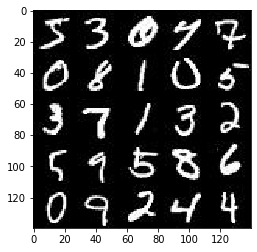

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

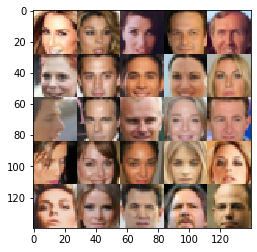

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.14.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [13]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_images')
    z_data = tf.placeholder(tf.float32, [None, z_dim], name='z_data')
    learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')

    return real_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [124]:
def discriminator(images, reuse=False, alpha=0.2, drop_rate=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer1 = tf.maximum(alpha * layer1, layer1)
        layer1 = tf.contrib.layers.dropout(layer1, keep_prob=(1 - drop_rate))
        
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2, padding='same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(alpha * layer2, layer2)
        layer2 = tf.contrib.layers.dropout(layer2, keep_prob=(1 - drop_rate))
        
        layer3 = tf.layers.conv2d(layer2, 256, 5, strides=2, padding='same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(alpha * layer3, layer3)
        layer3 = tf.contrib.layers.dropout(layer3, keep_prob=(1 - drop_rate))
        
        layer4 = tf.layers.conv2d(layer3, 512, 5, strides=2, padding='same', 
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer4 = tf.layers.batch_normalization(layer4, training=True)
        layer4 = tf.maximum(alpha * layer4, layer4)
        layer4 = tf.contrib.layers.dropout(layer4, keep_prob=(1 - drop_rate))
        
        flattened = tf.reshape(layer4, (-1, 4 * 4 * 512))
        logits = tf.contrib.layers.fully_connected(flattened, 1, activation_fn=None)
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [100]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        layer1 = tf.contrib.layers.fully_connected(z, 7 * 7 * 512)
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha * layer1, layer1)
        
        layer2 = tf.contrib.layers.conv2d_transpose(layer1, 256, 5, stride=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        
        layer3 = tf.contrib.layers.conv2d_transpose(layer2, 128, 5, stride=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)

        logits = tf.contrib.layers.conv2d_transpose(layer3, out_channel_dim, 5, stride=1, padding='same')
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [117]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_r, d_logits_r = discriminator(input_real)
    d_model_f, d_logits_f = discriminator(g_model, reuse=True)
    
    d_loss_r = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_r, 
                                                                      labels=tf.ones_like(d_model_r) * (1 - smooth)))
    d_loss_f = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_f, labels=tf.zeros_like(d_model_f)))
    d_loss_sum = d_loss_r + d_loss_f
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_f, labels=tf.ones_like(d_model_f)))
    
    return d_loss_sum, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [44]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [d_var for d_var in t_vars if d_var.name.startswith('discriminator')]
    g_vars = [g_var for g_var in t_vars if g_var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [45]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [46]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    
#     saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    
    _, height, width, channels = data_shape    
    real_images, z_images, learn_rate = model_inputs(height, width, channels, z_dim)
    
    d_loss, g_loss = model_loss(real_images, z_images, channels)
    d_train, g_train = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):                    
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train, feed_dict={ real_images: batch_images, z_images: batch_z, learn_rate: learning_rate })
                _ = sess.run(g_train, feed_dict={ real_images: batch_images, z_images: batch_z, learn_rate: learning_rate })
                
                if steps % 10 == 0:
                    t_loss_d = d_loss.eval({ real_images: batch_images, z_images: batch_z, learn_rate: learning_rate })
                    t_loss_g = g_loss.eval({ real_images: batch_images, z_images: batch_z, learn_rate: learning_rate })
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(t_loss_d),
                          "Generator Loss: {:.4f}".format(t_loss_g))
                    
                    losses.append((t_loss_d, t_loss_g))
                    
                if steps % 100 == 0:
                    g_samples = sess.run(
                        generator(z_images, channels, is_train=False), 
                        feed_dict={ z_images: batch_z })

                    samples.append(g_samples)
                    _ = show_generator_output(sess, 25, z_images, channels, data_image_mode)
                    
                    
#         saver.save(sess, './checkpoints/generator.ckpt')
        
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.0547... Generator Loss: 4.9182
Epoch 1/2... Discriminator Loss: 1.4139... Generator Loss: 12.2918
Epoch 1/2... Discriminator Loss: 1.2444... Generator Loss: 10.1983
Epoch 1/2... Discriminator Loss: 0.4907... Generator Loss: 8.6700
Epoch 1/2... Discriminator Loss: 0.3937... Generator Loss: 8.4906
Epoch 1/2... Discriminator Loss: 0.3632... Generator Loss: 9.4653
Epoch 1/2... Discriminator Loss: 0.3443... Generator Loss: 10.7827
Epoch 1/2... Discriminator Loss: 0.3567... Generator Loss: 9.4688
Epoch 1/2... Discriminator Loss: 0.4842... Generator Loss: 10.2923
Epoch 1/2... Discriminator Loss: 0.3555... Generator Loss: 10.8367


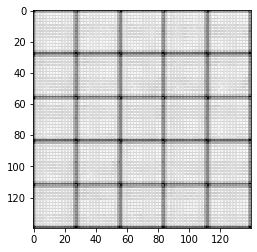

Epoch 1/2... Discriminator Loss: 0.3393... Generator Loss: 10.7469
Epoch 1/2... Discriminator Loss: 0.4217... Generator Loss: 10.1830
Epoch 1/2... Discriminator Loss: 0.3538... Generator Loss: 10.6067
Epoch 1/2... Discriminator Loss: 0.5416... Generator Loss: 9.0242
Epoch 1/2... Discriminator Loss: 0.3500... Generator Loss: 8.6502
Epoch 1/2... Discriminator Loss: 0.3479... Generator Loss: 8.6406
Epoch 1/2... Discriminator Loss: 0.3340... Generator Loss: 9.4711
Epoch 1/2... Discriminator Loss: 0.4287... Generator Loss: 8.7526
Epoch 1/2... Discriminator Loss: 0.3761... Generator Loss: 9.8252
Epoch 1/2... Discriminator Loss: 0.6471... Generator Loss: 7.4717


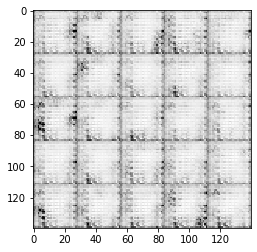

Epoch 1/2... Discriminator Loss: 0.4439... Generator Loss: 9.1264
Epoch 1/2... Discriminator Loss: 0.3631... Generator Loss: 10.6999
Epoch 1/2... Discriminator Loss: 0.3354... Generator Loss: 10.6152
Epoch 1/2... Discriminator Loss: 0.3968... Generator Loss: 9.5969
Epoch 1/2... Discriminator Loss: 0.3693... Generator Loss: 10.9203
Epoch 1/2... Discriminator Loss: 0.3449... Generator Loss: 10.5300
Epoch 1/2... Discriminator Loss: 0.4121... Generator Loss: 9.1871
Epoch 1/2... Discriminator Loss: 0.4784... Generator Loss: 8.5124
Epoch 1/2... Discriminator Loss: 0.3787... Generator Loss: 9.4107
Epoch 1/2... Discriminator Loss: 0.3782... Generator Loss: 8.7400


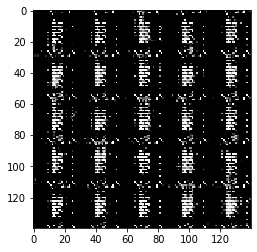

Epoch 1/2... Discriminator Loss: 0.4008... Generator Loss: 8.3652
Epoch 1/2... Discriminator Loss: 0.3432... Generator Loss: 9.7911
Epoch 1/2... Discriminator Loss: 0.3627... Generator Loss: 9.3889
Epoch 1/2... Discriminator Loss: 0.3710... Generator Loss: 8.6089
Epoch 1/2... Discriminator Loss: 0.3416... Generator Loss: 8.7568
Epoch 1/2... Discriminator Loss: 0.3605... Generator Loss: 8.6781
Epoch 1/2... Discriminator Loss: 0.3562... Generator Loss: 8.8037
Epoch 1/2... Discriminator Loss: 0.4089... Generator Loss: 9.6896
Epoch 1/2... Discriminator Loss: 0.3365... Generator Loss: 7.8761
Epoch 1/2... Discriminator Loss: 0.3476... Generator Loss: 8.1007


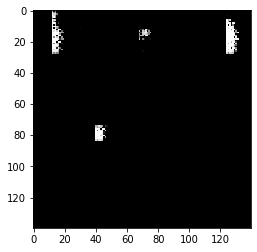

Epoch 1/2... Discriminator Loss: 0.4650... Generator Loss: 8.1956
Epoch 1/2... Discriminator Loss: 0.3380... Generator Loss: 8.8258
Epoch 1/2... Discriminator Loss: 0.3484... Generator Loss: 8.9705
Epoch 1/2... Discriminator Loss: 0.3716... Generator Loss: 9.0658
Epoch 1/2... Discriminator Loss: 0.5149... Generator Loss: 8.1347
Epoch 1/2... Discriminator Loss: 0.3476... Generator Loss: 8.5195
Epoch 1/2... Discriminator Loss: 0.3367... Generator Loss: 9.0218
Epoch 1/2... Discriminator Loss: 0.3466... Generator Loss: 9.9420
Epoch 1/2... Discriminator Loss: 0.3566... Generator Loss: 9.0315
Epoch 1/2... Discriminator Loss: 0.4637... Generator Loss: 8.9144


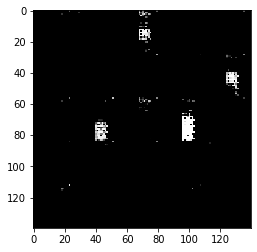

Epoch 1/2... Discriminator Loss: 0.3389... Generator Loss: 9.6920
Epoch 1/2... Discriminator Loss: 0.4456... Generator Loss: 8.6409
Epoch 1/2... Discriminator Loss: 0.3559... Generator Loss: 9.0850
Epoch 1/2... Discriminator Loss: 0.3394... Generator Loss: 9.7224
Epoch 1/2... Discriminator Loss: 0.3692... Generator Loss: 9.6354
Epoch 1/2... Discriminator Loss: 0.3722... Generator Loss: 8.8615
Epoch 1/2... Discriminator Loss: 0.3439... Generator Loss: 9.2954
Epoch 1/2... Discriminator Loss: 0.3459... Generator Loss: 9.0646
Epoch 1/2... Discriminator Loss: 0.3318... Generator Loss: 9.4047
Epoch 1/2... Discriminator Loss: 0.4090... Generator Loss: 8.5454


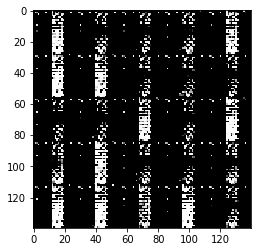

Epoch 1/2... Discriminator Loss: 0.3312... Generator Loss: 9.5850
Epoch 1/2... Discriminator Loss: 0.3755... Generator Loss: 8.1705
Epoch 1/2... Discriminator Loss: 0.3408... Generator Loss: 9.5279
Epoch 1/2... Discriminator Loss: 0.3539... Generator Loss: 9.9600
Epoch 1/2... Discriminator Loss: 0.3633... Generator Loss: 9.9817
Epoch 1/2... Discriminator Loss: 0.3334... Generator Loss: 9.4268
Epoch 1/2... Discriminator Loss: 0.3543... Generator Loss: 9.6349
Epoch 1/2... Discriminator Loss: 0.3335... Generator Loss: 9.9159
Epoch 1/2... Discriminator Loss: 0.3568... Generator Loss: 10.0623
Epoch 1/2... Discriminator Loss: 0.3390... Generator Loss: 9.8108


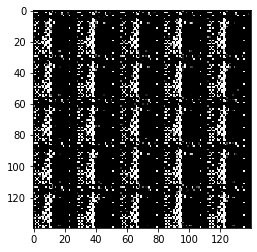

Epoch 1/2... Discriminator Loss: 0.3597... Generator Loss: 8.6969
Epoch 1/2... Discriminator Loss: 0.3537... Generator Loss: 9.6343
Epoch 1/2... Discriminator Loss: 0.3588... Generator Loss: 9.6177
Epoch 1/2... Discriminator Loss: 0.3393... Generator Loss: 9.6908
Epoch 1/2... Discriminator Loss: 0.3727... Generator Loss: 9.4191
Epoch 1/2... Discriminator Loss: 0.3828... Generator Loss: 9.2539
Epoch 1/2... Discriminator Loss: 0.3427... Generator Loss: 10.0246
Epoch 1/2... Discriminator Loss: 0.3563... Generator Loss: 9.9607
Epoch 1/2... Discriminator Loss: 0.3417... Generator Loss: 10.2795
Epoch 1/2... Discriminator Loss: 0.4503... Generator Loss: 9.4737


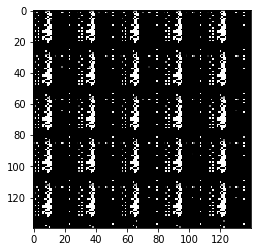

Epoch 1/2... Discriminator Loss: 0.3322... Generator Loss: 10.4443
Epoch 1/2... Discriminator Loss: 0.4434... Generator Loss: 10.3551
Epoch 1/2... Discriminator Loss: 0.3355... Generator Loss: 10.3187
Epoch 1/2... Discriminator Loss: 0.3323... Generator Loss: 10.6219
Epoch 1/2... Discriminator Loss: 0.3355... Generator Loss: 11.1788
Epoch 1/2... Discriminator Loss: 0.4205... Generator Loss: 10.7724
Epoch 1/2... Discriminator Loss: 0.3542... Generator Loss: 10.7187
Epoch 1/2... Discriminator Loss: 0.3325... Generator Loss: 10.5398
Epoch 1/2... Discriminator Loss: 0.4077... Generator Loss: 10.3502
Epoch 1/2... Discriminator Loss: 0.3307... Generator Loss: 10.6170


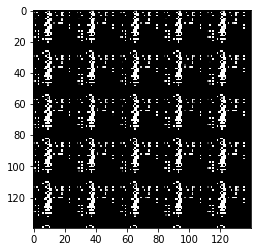

Epoch 1/2... Discriminator Loss: 0.3456... Generator Loss: 10.5574
Epoch 1/2... Discriminator Loss: 0.3476... Generator Loss: 10.8691
Epoch 1/2... Discriminator Loss: 0.3343... Generator Loss: 10.3458
Epoch 1/2... Discriminator Loss: 0.3818... Generator Loss: 10.2228
Epoch 1/2... Discriminator Loss: 0.3803... Generator Loss: 10.5330
Epoch 1/2... Discriminator Loss: 0.3894... Generator Loss: 10.8089
Epoch 1/2... Discriminator Loss: 0.3949... Generator Loss: 10.6904
Epoch 1/2... Discriminator Loss: 0.3315... Generator Loss: 11.1987
Epoch 1/2... Discriminator Loss: 0.3618... Generator Loss: 11.2878
Epoch 1/2... Discriminator Loss: 0.3555... Generator Loss: 11.3271


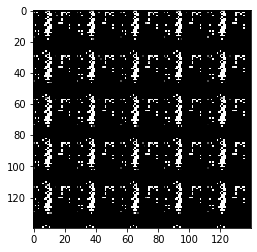

Epoch 1/2... Discriminator Loss: 0.3709... Generator Loss: 10.7006
Epoch 1/2... Discriminator Loss: 0.3388... Generator Loss: 10.7771
Epoch 1/2... Discriminator Loss: 0.3403... Generator Loss: 10.5580
Epoch 1/2... Discriminator Loss: 0.3290... Generator Loss: 10.8097
Epoch 1/2... Discriminator Loss: 0.3431... Generator Loss: 10.4858
Epoch 1/2... Discriminator Loss: 0.4026... Generator Loss: 10.5496
Epoch 1/2... Discriminator Loss: 0.3563... Generator Loss: 10.7398
Epoch 1/2... Discriminator Loss: 0.3755... Generator Loss: 10.1827
Epoch 1/2... Discriminator Loss: 0.3345... Generator Loss: 10.5081
Epoch 1/2... Discriminator Loss: 0.3330... Generator Loss: 10.9295


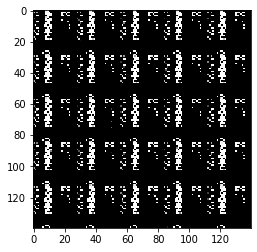

Epoch 1/2... Discriminator Loss: 0.3681... Generator Loss: 10.4407
Epoch 1/2... Discriminator Loss: 0.4106... Generator Loss: 10.1830
Epoch 1/2... Discriminator Loss: 0.3902... Generator Loss: 10.2286
Epoch 1/2... Discriminator Loss: 0.3549... Generator Loss: 9.8995
Epoch 1/2... Discriminator Loss: 0.3771... Generator Loss: 10.0294
Epoch 1/2... Discriminator Loss: 0.3838... Generator Loss: 9.7353
Epoch 1/2... Discriminator Loss: 0.3300... Generator Loss: 9.5855
Epoch 1/2... Discriminator Loss: 0.3513... Generator Loss: 10.1424
Epoch 1/2... Discriminator Loss: 0.3449... Generator Loss: 10.1739
Epoch 1/2... Discriminator Loss: 0.3431... Generator Loss: 10.2732


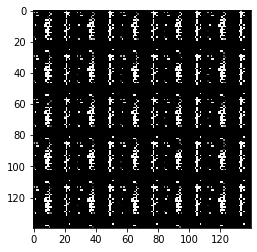

Epoch 1/2... Discriminator Loss: 0.3417... Generator Loss: 9.8197
Epoch 1/2... Discriminator Loss: 0.3463... Generator Loss: 9.5064
Epoch 1/2... Discriminator Loss: 0.3425... Generator Loss: 9.1725
Epoch 1/2... Discriminator Loss: 0.3371... Generator Loss: 9.2975
Epoch 1/2... Discriminator Loss: 0.3369... Generator Loss: 9.7814
Epoch 1/2... Discriminator Loss: 0.3482... Generator Loss: 9.7210
Epoch 1/2... Discriminator Loss: 0.3530... Generator Loss: 9.3257
Epoch 1/2... Discriminator Loss: 0.3541... Generator Loss: 8.9445
Epoch 1/2... Discriminator Loss: 0.3364... Generator Loss: 9.2307
Epoch 1/2... Discriminator Loss: 0.3441... Generator Loss: 8.9701


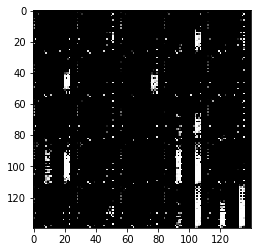

Epoch 1/2... Discriminator Loss: 0.3443... Generator Loss: 8.7251
Epoch 1/2... Discriminator Loss: 0.3372... Generator Loss: 8.9939
Epoch 1/2... Discriminator Loss: 0.3443... Generator Loss: 8.8203
Epoch 1/2... Discriminator Loss: 0.3460... Generator Loss: 8.3565
Epoch 1/2... Discriminator Loss: 0.3402... Generator Loss: 8.6419
Epoch 1/2... Discriminator Loss: 0.3479... Generator Loss: 8.7396
Epoch 1/2... Discriminator Loss: 0.3599... Generator Loss: 8.9642
Epoch 1/2... Discriminator Loss: 0.3318... Generator Loss: 9.0708
Epoch 1/2... Discriminator Loss: 0.3868... Generator Loss: 8.8242
Epoch 1/2... Discriminator Loss: 0.3640... Generator Loss: 8.8991


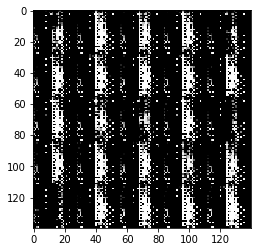

Epoch 1/2... Discriminator Loss: 0.3837... Generator Loss: 8.8622
Epoch 1/2... Discriminator Loss: 0.3571... Generator Loss: 9.2227
Epoch 1/2... Discriminator Loss: 0.3511... Generator Loss: 9.4509
Epoch 1/2... Discriminator Loss: 0.3622... Generator Loss: 9.0811
Epoch 1/2... Discriminator Loss: 0.3803... Generator Loss: 9.5330
Epoch 1/2... Discriminator Loss: 0.3400... Generator Loss: 10.2701
Epoch 1/2... Discriminator Loss: 0.3404... Generator Loss: 10.0839
Epoch 1/2... Discriminator Loss: 0.3349... Generator Loss: 10.0318
Epoch 1/2... Discriminator Loss: 0.3321... Generator Loss: 10.0137
Epoch 1/2... Discriminator Loss: 0.3625... Generator Loss: 9.9094


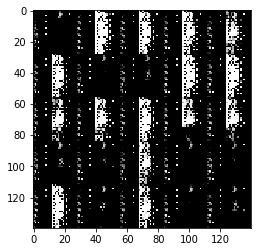

Epoch 1/2... Discriminator Loss: 0.3852... Generator Loss: 9.5585
Epoch 1/2... Discriminator Loss: 0.3777... Generator Loss: 9.3864
Epoch 1/2... Discriminator Loss: 0.3703... Generator Loss: 9.6392
Epoch 1/2... Discriminator Loss: 0.3858... Generator Loss: 9.4426
Epoch 1/2... Discriminator Loss: 0.3398... Generator Loss: 9.7104
Epoch 1/2... Discriminator Loss: 0.3953... Generator Loss: 9.4515
Epoch 1/2... Discriminator Loss: 0.3768... Generator Loss: 9.7378
Epoch 1/2... Discriminator Loss: 0.3291... Generator Loss: 10.1695
Epoch 1/2... Discriminator Loss: 0.3414... Generator Loss: 10.3922
Epoch 1/2... Discriminator Loss: 0.3304... Generator Loss: 10.5394


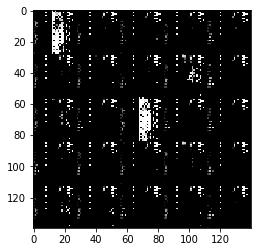

Epoch 1/2... Discriminator Loss: 0.3424... Generator Loss: 10.6760
Epoch 1/2... Discriminator Loss: 0.3493... Generator Loss: 10.5524
Epoch 1/2... Discriminator Loss: 0.3396... Generator Loss: 10.3193
Epoch 1/2... Discriminator Loss: 0.3464... Generator Loss: 10.6103
Epoch 1/2... Discriminator Loss: 0.3404... Generator Loss: 10.7571
Epoch 1/2... Discriminator Loss: 0.3398... Generator Loss: 10.5601
Epoch 1/2... Discriminator Loss: 0.3487... Generator Loss: 10.7278
Epoch 1/2... Discriminator Loss: 0.3392... Generator Loss: 10.5316
Epoch 1/2... Discriminator Loss: 0.3474... Generator Loss: 10.4442
Epoch 1/2... Discriminator Loss: 0.3336... Generator Loss: 10.6278


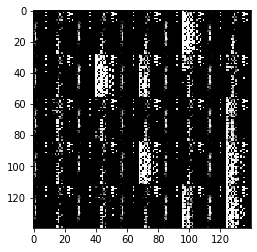

Epoch 1/2... Discriminator Loss: 0.3498... Generator Loss: 10.5089
Epoch 1/2... Discriminator Loss: 0.3433... Generator Loss: 10.2925
Epoch 1/2... Discriminator Loss: 0.3457... Generator Loss: 10.3390
Epoch 1/2... Discriminator Loss: 0.3461... Generator Loss: 10.3397
Epoch 1/2... Discriminator Loss: 0.3426... Generator Loss: 10.6223
Epoch 1/2... Discriminator Loss: 0.3400... Generator Loss: 10.1697
Epoch 1/2... Discriminator Loss: 0.3419... Generator Loss: 10.1283
Epoch 1/2... Discriminator Loss: 0.3376... Generator Loss: 10.4510
Epoch 1/2... Discriminator Loss: 0.3306... Generator Loss: 10.2819
Epoch 1/2... Discriminator Loss: 0.3400... Generator Loss: 10.2698


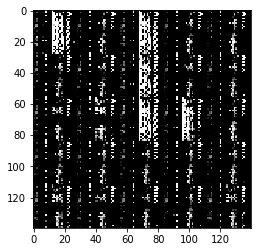

Epoch 1/2... Discriminator Loss: 0.3456... Generator Loss: 9.7547
Epoch 1/2... Discriminator Loss: 0.3434... Generator Loss: 10.0691
Epoch 1/2... Discriminator Loss: 0.3407... Generator Loss: 10.1682
Epoch 1/2... Discriminator Loss: 0.3367... Generator Loss: 10.1354
Epoch 1/2... Discriminator Loss: 0.3332... Generator Loss: 10.3222
Epoch 1/2... Discriminator Loss: 0.3280... Generator Loss: 10.4072
Epoch 1/2... Discriminator Loss: 0.3302... Generator Loss: 10.3391
Epoch 2/2... Discriminator Loss: 0.3690... Generator Loss: 10.2390
Epoch 2/2... Discriminator Loss: 0.3407... Generator Loss: 10.1957
Epoch 2/2... Discriminator Loss: 0.3743... Generator Loss: 10.0115


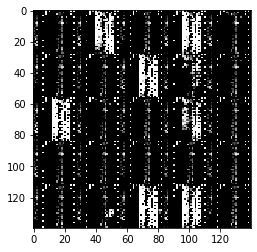

Epoch 2/2... Discriminator Loss: 0.3573... Generator Loss: 10.1376
Epoch 2/2... Discriminator Loss: 0.3561... Generator Loss: 10.1455
Epoch 2/2... Discriminator Loss: 0.3537... Generator Loss: 10.0803
Epoch 2/2... Discriminator Loss: 0.3847... Generator Loss: 9.8340
Epoch 2/2... Discriminator Loss: 0.3445... Generator Loss: 10.4270
Epoch 2/2... Discriminator Loss: 0.3543... Generator Loss: 10.2727
Epoch 2/2... Discriminator Loss: 0.3590... Generator Loss: 10.3616
Epoch 2/2... Discriminator Loss: 0.3477... Generator Loss: 10.2661
Epoch 2/2... Discriminator Loss: 0.3378... Generator Loss: 10.4992
Epoch 2/2... Discriminator Loss: 0.3587... Generator Loss: 10.3787


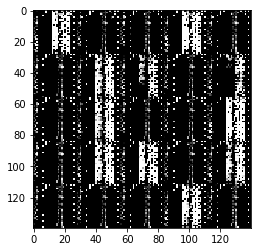

Epoch 2/2... Discriminator Loss: 0.3285... Generator Loss: 10.5641
Epoch 2/2... Discriminator Loss: 0.3385... Generator Loss: 10.4391
Epoch 2/2... Discriminator Loss: 0.3593... Generator Loss: 10.1948
Epoch 2/2... Discriminator Loss: 0.3427... Generator Loss: 10.0134
Epoch 2/2... Discriminator Loss: 0.3290... Generator Loss: 10.2773
Epoch 2/2... Discriminator Loss: 0.3641... Generator Loss: 9.9996
Epoch 2/2... Discriminator Loss: 0.3283... Generator Loss: 10.2840
Epoch 2/2... Discriminator Loss: 0.3477... Generator Loss: 10.1601
Epoch 2/2... Discriminator Loss: 0.3657... Generator Loss: 9.9848
Epoch 2/2... Discriminator Loss: 0.3433... Generator Loss: 10.1341


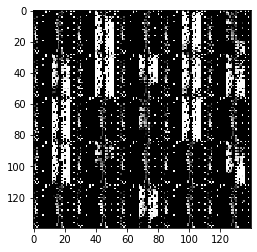

Epoch 2/2... Discriminator Loss: 0.3344... Generator Loss: 10.4096
Epoch 2/2... Discriminator Loss: 0.3494... Generator Loss: 9.6623
Epoch 2/2... Discriminator Loss: 0.3377... Generator Loss: 10.0913
Epoch 2/2... Discriminator Loss: 0.3442... Generator Loss: 10.0841
Epoch 2/2... Discriminator Loss: 0.3476... Generator Loss: 10.2461
Epoch 2/2... Discriminator Loss: 0.3584... Generator Loss: 9.8603
Epoch 2/2... Discriminator Loss: 0.3693... Generator Loss: 9.7753
Epoch 2/2... Discriminator Loss: 0.3488... Generator Loss: 9.8172
Epoch 2/2... Discriminator Loss: 0.3632... Generator Loss: 9.9309
Epoch 2/2... Discriminator Loss: 0.3360... Generator Loss: 10.1027


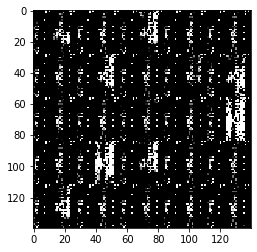

Epoch 2/2... Discriminator Loss: 0.3404... Generator Loss: 10.6942
Epoch 2/2... Discriminator Loss: 0.3418... Generator Loss: 10.6541
Epoch 2/2... Discriminator Loss: 0.3383... Generator Loss: 10.5215
Epoch 2/2... Discriminator Loss: 0.3343... Generator Loss: 10.4387
Epoch 2/2... Discriminator Loss: 0.3336... Generator Loss: 9.2421
Epoch 2/2... Discriminator Loss: 0.3402... Generator Loss: 9.3565
Epoch 2/2... Discriminator Loss: 0.3406... Generator Loss: 9.6322
Epoch 2/2... Discriminator Loss: 0.3412... Generator Loss: 9.5362
Epoch 2/2... Discriminator Loss: 0.3374... Generator Loss: 9.4656
Epoch 2/2... Discriminator Loss: 0.3412... Generator Loss: 9.7663


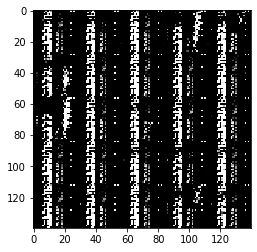

Epoch 2/2... Discriminator Loss: 0.3278... Generator Loss: 10.0233
Epoch 2/2... Discriminator Loss: 0.3363... Generator Loss: 10.0977
Epoch 2/2... Discriminator Loss: 0.3359... Generator Loss: 10.1968
Epoch 2/2... Discriminator Loss: 0.3373... Generator Loss: 9.9201
Epoch 2/2... Discriminator Loss: 0.3368... Generator Loss: 9.9424
Epoch 2/2... Discriminator Loss: 0.3394... Generator Loss: 9.9913
Epoch 2/2... Discriminator Loss: 0.3328... Generator Loss: 10.1127
Epoch 2/2... Discriminator Loss: 0.3418... Generator Loss: 10.0179
Epoch 2/2... Discriminator Loss: 0.3436... Generator Loss: 10.0484
Epoch 2/2... Discriminator Loss: 0.3385... Generator Loss: 10.0550


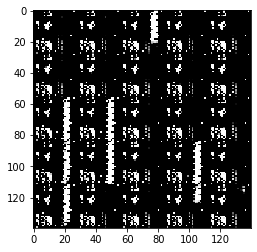

Epoch 2/2... Discriminator Loss: 0.3329... Generator Loss: 10.1279
Epoch 2/2... Discriminator Loss: 0.3362... Generator Loss: 10.1635
Epoch 2/2... Discriminator Loss: 0.3338... Generator Loss: 10.0580
Epoch 2/2... Discriminator Loss: 0.3341... Generator Loss: 9.8698
Epoch 2/2... Discriminator Loss: 0.3440... Generator Loss: 9.8464
Epoch 2/2... Discriminator Loss: 0.3314... Generator Loss: 10.2649
Epoch 2/2... Discriminator Loss: 0.3343... Generator Loss: 10.3315
Epoch 2/2... Discriminator Loss: 0.3330... Generator Loss: 10.5175
Epoch 2/2... Discriminator Loss: 0.3369... Generator Loss: 10.3889
Epoch 2/2... Discriminator Loss: 0.3361... Generator Loss: 10.5439


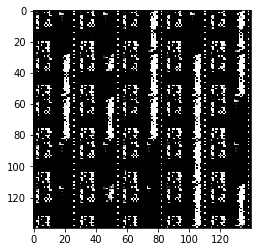

Epoch 2/2... Discriminator Loss: 0.3337... Generator Loss: 10.7821
Epoch 2/2... Discriminator Loss: 0.3355... Generator Loss: 10.5001
Epoch 2/2... Discriminator Loss: 0.3370... Generator Loss: 10.5207
Epoch 2/2... Discriminator Loss: 0.3370... Generator Loss: 10.9458
Epoch 2/2... Discriminator Loss: 0.3326... Generator Loss: 10.9003
Epoch 2/2... Discriminator Loss: 0.3399... Generator Loss: 10.8003
Epoch 2/2... Discriminator Loss: 0.3402... Generator Loss: 10.8372
Epoch 2/2... Discriminator Loss: 0.3339... Generator Loss: 10.8992
Epoch 2/2... Discriminator Loss: 0.3363... Generator Loss: 10.8571
Epoch 2/2... Discriminator Loss: 0.3358... Generator Loss: 10.9578


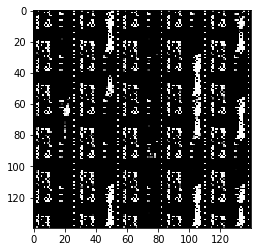

Epoch 2/2... Discriminator Loss: 0.3381... Generator Loss: 10.4605
Epoch 2/2... Discriminator Loss: 0.3343... Generator Loss: 10.6959
Epoch 2/2... Discriminator Loss: 0.3324... Generator Loss: 10.8631
Epoch 2/2... Discriminator Loss: 0.3298... Generator Loss: 10.8169
Epoch 2/2... Discriminator Loss: 0.3348... Generator Loss: 11.0351
Epoch 2/2... Discriminator Loss: 0.3268... Generator Loss: 10.9523
Epoch 2/2... Discriminator Loss: 0.3266... Generator Loss: 11.0067
Epoch 2/2... Discriminator Loss: 0.3354... Generator Loss: 10.9330
Epoch 2/2... Discriminator Loss: 0.3436... Generator Loss: 10.8741
Epoch 2/2... Discriminator Loss: 0.3307... Generator Loss: 10.8870


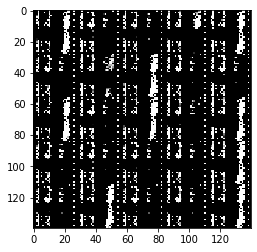

Epoch 2/2... Discriminator Loss: 0.3378... Generator Loss: 10.9763
Epoch 2/2... Discriminator Loss: 0.3677... Generator Loss: 10.8851
Epoch 2/2... Discriminator Loss: 0.3392... Generator Loss: 10.8112
Epoch 2/2... Discriminator Loss: 0.3405... Generator Loss: 10.5830
Epoch 2/2... Discriminator Loss: 0.3515... Generator Loss: 10.5774
Epoch 2/2... Discriminator Loss: 0.3478... Generator Loss: 10.0515
Epoch 2/2... Discriminator Loss: 0.3453... Generator Loss: 9.9647
Epoch 2/2... Discriminator Loss: 0.3472... Generator Loss: 10.0745
Epoch 2/2... Discriminator Loss: 0.3472... Generator Loss: 9.9600
Epoch 2/2... Discriminator Loss: 0.3418... Generator Loss: 10.1285


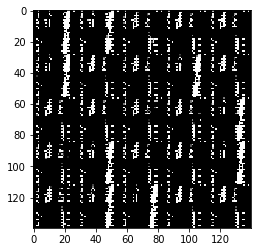

Epoch 2/2... Discriminator Loss: 0.3313... Generator Loss: 10.2313
Epoch 2/2... Discriminator Loss: 0.3429... Generator Loss: 10.4647
Epoch 2/2... Discriminator Loss: 0.3499... Generator Loss: 10.4228
Epoch 2/2... Discriminator Loss: 0.3385... Generator Loss: 10.6453
Epoch 2/2... Discriminator Loss: 0.3503... Generator Loss: 10.5700
Epoch 2/2... Discriminator Loss: 0.3343... Generator Loss: 10.7103
Epoch 2/2... Discriminator Loss: 0.3516... Generator Loss: 10.4722
Epoch 2/2... Discriminator Loss: 0.3430... Generator Loss: 10.5416
Epoch 2/2... Discriminator Loss: 0.3324... Generator Loss: 10.3338
Epoch 2/2... Discriminator Loss: 0.3414... Generator Loss: 10.3053


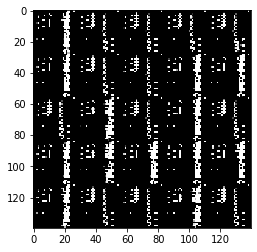

Epoch 2/2... Discriminator Loss: 0.3348... Generator Loss: 10.5378
Epoch 2/2... Discriminator Loss: 0.3297... Generator Loss: 10.2896
Epoch 2/2... Discriminator Loss: 0.3291... Generator Loss: 9.8931
Epoch 2/2... Discriminator Loss: 0.3391... Generator Loss: 9.5585
Epoch 2/2... Discriminator Loss: 0.3399... Generator Loss: 9.2241
Epoch 2/2... Discriminator Loss: 0.3492... Generator Loss: 8.5481
Epoch 2/2... Discriminator Loss: 0.3558... Generator Loss: 8.6707
Epoch 2/2... Discriminator Loss: 0.3381... Generator Loss: 9.3963
Epoch 2/2... Discriminator Loss: 0.3435... Generator Loss: 9.4098
Epoch 2/2... Discriminator Loss: 0.3434... Generator Loss: 9.5153


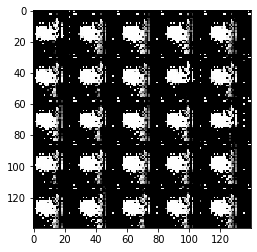

Epoch 2/2... Discriminator Loss: 0.3292... Generator Loss: 10.0347
Epoch 2/2... Discriminator Loss: 0.3357... Generator Loss: 10.1076
Epoch 2/2... Discriminator Loss: 0.3381... Generator Loss: 10.0899
Epoch 2/2... Discriminator Loss: 0.3331... Generator Loss: 10.0762
Epoch 2/2... Discriminator Loss: 0.3396... Generator Loss: 10.2198
Epoch 2/2... Discriminator Loss: 0.3484... Generator Loss: 10.0700
Epoch 2/2... Discriminator Loss: 0.3390... Generator Loss: 10.1410
Epoch 2/2... Discriminator Loss: 0.3387... Generator Loss: 10.2590
Epoch 2/2... Discriminator Loss: 0.3390... Generator Loss: 10.4952
Epoch 2/2... Discriminator Loss: 0.3354... Generator Loss: 10.4055


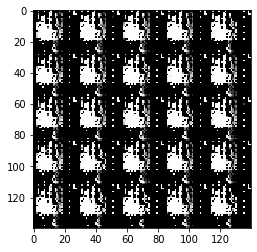

Epoch 2/2... Discriminator Loss: 0.3371... Generator Loss: 10.2905
Epoch 2/2... Discriminator Loss: 0.3303... Generator Loss: 10.2608
Epoch 2/2... Discriminator Loss: 0.3355... Generator Loss: 10.3069
Epoch 2/2... Discriminator Loss: 0.3290... Generator Loss: 10.4666
Epoch 2/2... Discriminator Loss: 0.3296... Generator Loss: 10.4782
Epoch 2/2... Discriminator Loss: 0.3290... Generator Loss: 10.3101
Epoch 2/2... Discriminator Loss: 0.3392... Generator Loss: 10.4933
Epoch 2/2... Discriminator Loss: 0.3614... Generator Loss: 10.1279
Epoch 2/2... Discriminator Loss: 0.3341... Generator Loss: 10.5213
Epoch 2/2... Discriminator Loss: 0.3589... Generator Loss: 10.0527


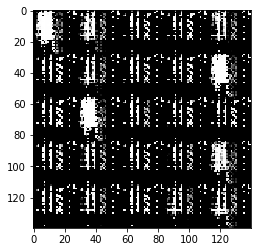

Epoch 2/2... Discriminator Loss: 0.3390... Generator Loss: 10.0746
Epoch 2/2... Discriminator Loss: 0.3353... Generator Loss: 10.0629
Epoch 2/2... Discriminator Loss: 0.3440... Generator Loss: 9.9787
Epoch 2/2... Discriminator Loss: 0.3288... Generator Loss: 10.1215
Epoch 2/2... Discriminator Loss: 0.3483... Generator Loss: 9.9724
Epoch 2/2... Discriminator Loss: 0.3411... Generator Loss: 9.9211


KeyboardInterrupt: 

In [123]:
batch_size = 32
z_dim = 100
learning_rate = 0.0006
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7853... Generator Loss: 2.2247
Epoch 1/1... Discriminator Loss: 0.5591... Generator Loss: 4.8268
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 4.7934
Epoch 1/1... Discriminator Loss: 0.5886... Generator Loss: 4.9596
Epoch 1/1... Discriminator Loss: 0.6586... Generator Loss: 5.3351
Epoch 1/1... Discriminator Loss: 0.3634... Generator Loss: 6.7678
Epoch 1/1... Discriminator Loss: 0.3460... Generator Loss: 7.6682
Epoch 1/1... Discriminator Loss: 0.3565... Generator Loss: 6.8075
Epoch 1/1... Discriminator Loss: 0.3909... Generator Loss: 7.2913
Epoch 1/1... Discriminator Loss: 0.3569... Generator Loss: 7.0183


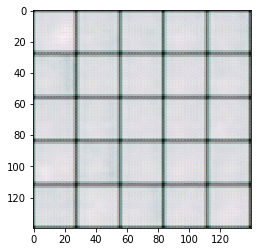

Epoch 1/1... Discriminator Loss: 0.3424... Generator Loss: 7.1015
Epoch 1/1... Discriminator Loss: 0.5300... Generator Loss: 5.3182
Epoch 1/1... Discriminator Loss: 0.3541... Generator Loss: 7.5264
Epoch 1/1... Discriminator Loss: 0.5574... Generator Loss: 5.4218
Epoch 1/1... Discriminator Loss: 0.3463... Generator Loss: 8.1343
Epoch 1/1... Discriminator Loss: 0.3303... Generator Loss: 7.6766
Epoch 1/1... Discriminator Loss: 0.3763... Generator Loss: 7.8687
Epoch 1/1... Discriminator Loss: 0.3625... Generator Loss: 8.3898
Epoch 1/1... Discriminator Loss: 0.3597... Generator Loss: 7.7335
Epoch 1/1... Discriminator Loss: 0.3558... Generator Loss: 7.7241


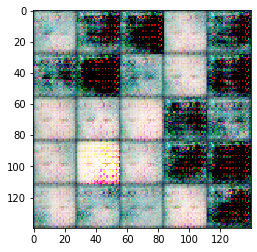

Epoch 1/1... Discriminator Loss: 0.3384... Generator Loss: 7.9348
Epoch 1/1... Discriminator Loss: 0.3419... Generator Loss: 8.2488
Epoch 1/1... Discriminator Loss: 0.4899... Generator Loss: 7.2309
Epoch 1/1... Discriminator Loss: 0.3424... Generator Loss: 8.8830
Epoch 1/1... Discriminator Loss: 0.3417... Generator Loss: 8.4789
Epoch 1/1... Discriminator Loss: 0.3392... Generator Loss: 8.4875
Epoch 1/1... Discriminator Loss: 0.4828... Generator Loss: 7.5805
Epoch 1/1... Discriminator Loss: 0.3810... Generator Loss: 7.9252
Epoch 1/1... Discriminator Loss: 0.4287... Generator Loss: 7.3339
Epoch 1/1... Discriminator Loss: 0.4509... Generator Loss: 7.8365


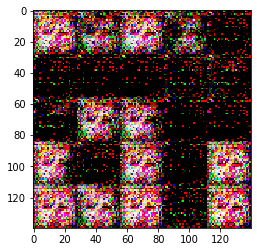

Epoch 1/1... Discriminator Loss: 0.3378... Generator Loss: 8.7085
Epoch 1/1... Discriminator Loss: 0.3907... Generator Loss: 8.7728
Epoch 1/1... Discriminator Loss: 0.3377... Generator Loss: 8.6602
Epoch 1/1... Discriminator Loss: 0.3498... Generator Loss: 8.6051
Epoch 1/1... Discriminator Loss: 0.3604... Generator Loss: 8.6215
Epoch 1/1... Discriminator Loss: 0.3361... Generator Loss: 8.6720
Epoch 1/1... Discriminator Loss: 0.3871... Generator Loss: 7.6933
Epoch 1/1... Discriminator Loss: 0.3465... Generator Loss: 8.7873
Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 8.5547
Epoch 1/1... Discriminator Loss: 0.3567... Generator Loss: 9.5071


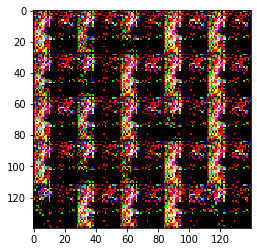

Epoch 1/1... Discriminator Loss: 0.3852... Generator Loss: 8.9890
Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 9.2610
Epoch 1/1... Discriminator Loss: 0.3465... Generator Loss: 9.7366
Epoch 1/1... Discriminator Loss: 0.3539... Generator Loss: 8.7819
Epoch 1/1... Discriminator Loss: 0.4106... Generator Loss: 9.0446
Epoch 1/1... Discriminator Loss: 0.3641... Generator Loss: 8.0054
Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 9.1433
Epoch 1/1... Discriminator Loss: 0.3403... Generator Loss: 8.9617
Epoch 1/1... Discriminator Loss: 0.3400... Generator Loss: 9.2655
Epoch 1/1... Discriminator Loss: 0.3350... Generator Loss: 8.4940


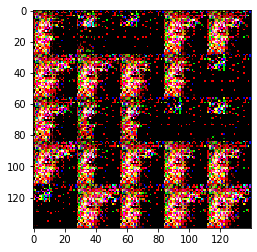

Epoch 1/1... Discriminator Loss: 0.3399... Generator Loss: 8.8914
Epoch 1/1... Discriminator Loss: 0.3554... Generator Loss: 9.5515
Epoch 1/1... Discriminator Loss: 0.3810... Generator Loss: 9.0244
Epoch 1/1... Discriminator Loss: 0.4411... Generator Loss: 8.0132
Epoch 1/1... Discriminator Loss: 0.3398... Generator Loss: 8.5878
Epoch 1/1... Discriminator Loss: 0.3949... Generator Loss: 8.7040
Epoch 1/1... Discriminator Loss: 0.4463... Generator Loss: 6.6464
Epoch 1/1... Discriminator Loss: 0.3365... Generator Loss: 8.3754
Epoch 1/1... Discriminator Loss: 0.3507... Generator Loss: 8.0628
Epoch 1/1... Discriminator Loss: 0.3660... Generator Loss: 8.4560


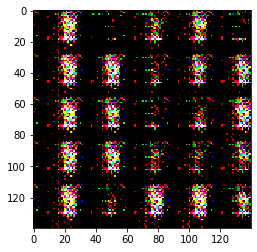

Epoch 1/1... Discriminator Loss: 0.3514... Generator Loss: 8.8665
Epoch 1/1... Discriminator Loss: 0.3318... Generator Loss: 8.8510
Epoch 1/1... Discriminator Loss: 0.3564... Generator Loss: 8.5218
Epoch 1/1... Discriminator Loss: 0.3389... Generator Loss: 8.9584
Epoch 1/1... Discriminator Loss: 0.3461... Generator Loss: 9.3952
Epoch 1/1... Discriminator Loss: 0.3377... Generator Loss: 9.2167
Epoch 1/1... Discriminator Loss: 0.3311... Generator Loss: 9.5462
Epoch 1/1... Discriminator Loss: 0.3677... Generator Loss: 8.6592
Epoch 1/1... Discriminator Loss: 0.3359... Generator Loss: 9.9103
Epoch 1/1... Discriminator Loss: 0.3378... Generator Loss: 9.4034


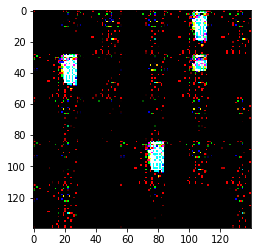

Epoch 1/1... Discriminator Loss: 0.3364... Generator Loss: 9.4612
Epoch 1/1... Discriminator Loss: 0.3478... Generator Loss: 9.5496
Epoch 1/1... Discriminator Loss: 0.3355... Generator Loss: 9.8864
Epoch 1/1... Discriminator Loss: 0.3314... Generator Loss: 9.8548
Epoch 1/1... Discriminator Loss: 0.3407... Generator Loss: 9.3562
Epoch 1/1... Discriminator Loss: 0.3473... Generator Loss: 9.2195
Epoch 1/1... Discriminator Loss: 0.3420... Generator Loss: 8.4997
Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 9.1450
Epoch 1/1... Discriminator Loss: 0.3460... Generator Loss: 8.8341
Epoch 1/1... Discriminator Loss: 0.3332... Generator Loss: 9.6369


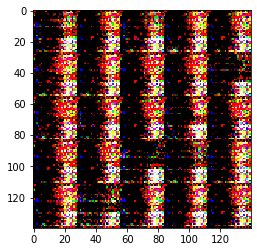

Epoch 1/1... Discriminator Loss: 0.3315... Generator Loss: 9.3641
Epoch 1/1... Discriminator Loss: 0.3400... Generator Loss: 9.4963
Epoch 1/1... Discriminator Loss: 0.3325... Generator Loss: 9.8317
Epoch 1/1... Discriminator Loss: 0.3337... Generator Loss: 9.8809
Epoch 1/1... Discriminator Loss: 0.4045... Generator Loss: 9.3037
Epoch 1/1... Discriminator Loss: 0.3355... Generator Loss: 10.5444
Epoch 1/1... Discriminator Loss: 0.3328... Generator Loss: 9.5291
Epoch 1/1... Discriminator Loss: 0.3352... Generator Loss: 10.6003
Epoch 1/1... Discriminator Loss: 0.3340... Generator Loss: 10.2917
Epoch 1/1... Discriminator Loss: 0.3381... Generator Loss: 10.6162


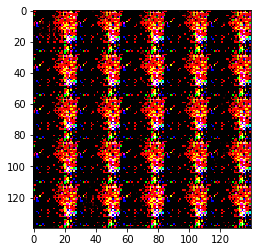

Epoch 1/1... Discriminator Loss: 0.3318... Generator Loss: 10.1562
Epoch 1/1... Discriminator Loss: 0.3427... Generator Loss: 10.1957
Epoch 1/1... Discriminator Loss: 0.3303... Generator Loss: 10.0563
Epoch 1/1... Discriminator Loss: 0.3342... Generator Loss: 9.7427
Epoch 1/1... Discriminator Loss: 0.3307... Generator Loss: 9.8326
Epoch 1/1... Discriminator Loss: 0.3545... Generator Loss: 9.9332
Epoch 1/1... Discriminator Loss: 0.3445... Generator Loss: 10.2158
Epoch 1/1... Discriminator Loss: 0.3359... Generator Loss: 9.6636
Epoch 1/1... Discriminator Loss: 0.3556... Generator Loss: 9.2340
Epoch 1/1... Discriminator Loss: 0.3347... Generator Loss: 8.8649


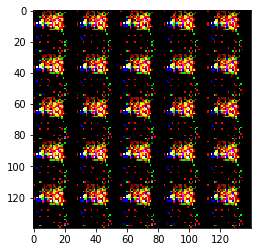

Epoch 1/1... Discriminator Loss: 0.3484... Generator Loss: 8.8805
Epoch 1/1... Discriminator Loss: 0.3850... Generator Loss: 8.3533
Epoch 1/1... Discriminator Loss: 0.3328... Generator Loss: 10.0923
Epoch 1/1... Discriminator Loss: 0.3355... Generator Loss: 9.8878
Epoch 1/1... Discriminator Loss: 0.3478... Generator Loss: 9.5694
Epoch 1/1... Discriminator Loss: 0.3294... Generator Loss: 9.7470
Epoch 1/1... Discriminator Loss: 0.3344... Generator Loss: 9.5944
Epoch 1/1... Discriminator Loss: 0.3331... Generator Loss: 9.8611
Epoch 1/1... Discriminator Loss: 0.3577... Generator Loss: 9.4267
Epoch 1/1... Discriminator Loss: 0.4311... Generator Loss: 9.1094


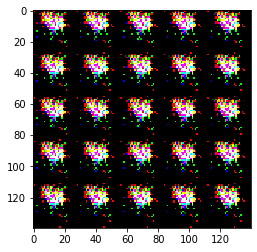

Epoch 1/1... Discriminator Loss: 0.3403... Generator Loss: 9.7749
Epoch 1/1... Discriminator Loss: 0.3331... Generator Loss: 9.6882
Epoch 1/1... Discriminator Loss: 0.3415... Generator Loss: 9.7482
Epoch 1/1... Discriminator Loss: 0.3345... Generator Loss: 8.7734
Epoch 1/1... Discriminator Loss: 0.3539... Generator Loss: 9.0020
Epoch 1/1... Discriminator Loss: 0.3362... Generator Loss: 8.1640
Epoch 1/1... Discriminator Loss: 0.3292... Generator Loss: 9.3812
Epoch 1/1... Discriminator Loss: 0.3472... Generator Loss: 9.9676
Epoch 1/1... Discriminator Loss: 0.3299... Generator Loss: 10.5351
Epoch 1/1... Discriminator Loss: 0.3351... Generator Loss: 10.1218


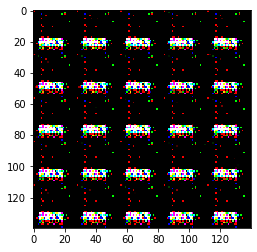

Epoch 1/1... Discriminator Loss: 0.3401... Generator Loss: 10.7391
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 9.6266
Epoch 1/1... Discriminator Loss: 0.3293... Generator Loss: 10.4474
Epoch 1/1... Discriminator Loss: 0.3349... Generator Loss: 10.8287
Epoch 1/1... Discriminator Loss: 0.3398... Generator Loss: 10.7329
Epoch 1/1... Discriminator Loss: 0.3315... Generator Loss: 10.3757
Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 11.2868
Epoch 1/1... Discriminator Loss: 0.3298... Generator Loss: 10.7349
Epoch 1/1... Discriminator Loss: 0.3840... Generator Loss: 9.8693
Epoch 1/1... Discriminator Loss: 0.3435... Generator Loss: 9.9867


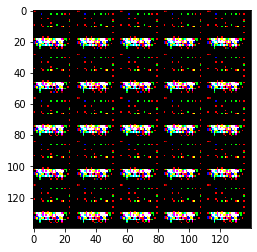

Epoch 1/1... Discriminator Loss: 0.3294... Generator Loss: 10.8949
Epoch 1/1... Discriminator Loss: 0.3323... Generator Loss: 10.7627
Epoch 1/1... Discriminator Loss: 0.3334... Generator Loss: 11.0004
Epoch 1/1... Discriminator Loss: 0.3437... Generator Loss: 10.8432
Epoch 1/1... Discriminator Loss: 0.3355... Generator Loss: 11.1763
Epoch 1/1... Discriminator Loss: 0.3348... Generator Loss: 10.2253
Epoch 1/1... Discriminator Loss: 0.3479... Generator Loss: 10.9327
Epoch 1/1... Discriminator Loss: 0.3557... Generator Loss: 10.1862
Epoch 1/1... Discriminator Loss: 0.3333... Generator Loss: 9.8112
Epoch 1/1... Discriminator Loss: 0.3461... Generator Loss: 7.0394


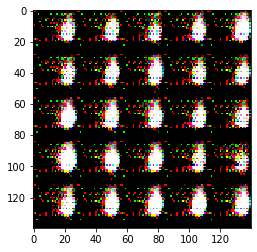

Epoch 1/1... Discriminator Loss: 0.3340... Generator Loss: 8.8165
Epoch 1/1... Discriminator Loss: 0.3320... Generator Loss: 9.3613
Epoch 1/1... Discriminator Loss: 0.3363... Generator Loss: 9.5069
Epoch 1/1... Discriminator Loss: 0.3568... Generator Loss: 9.7933
Epoch 1/1... Discriminator Loss: 0.3304... Generator Loss: 10.0422
Epoch 1/1... Discriminator Loss: 0.3393... Generator Loss: 10.8858
Epoch 1/1... Discriminator Loss: 0.3316... Generator Loss: 10.2624
Epoch 1/1... Discriminator Loss: 0.3395... Generator Loss: 10.2906
Epoch 1/1... Discriminator Loss: 0.3300... Generator Loss: 10.3484
Epoch 1/1... Discriminator Loss: 0.3293... Generator Loss: 10.6732


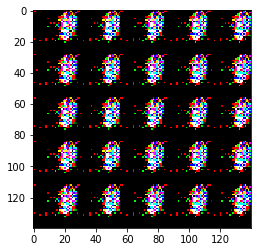

Epoch 1/1... Discriminator Loss: 0.3606... Generator Loss: 9.9275
Epoch 1/1... Discriminator Loss: 0.3353... Generator Loss: 10.3923
Epoch 1/1... Discriminator Loss: 0.3362... Generator Loss: 8.9259
Epoch 1/1... Discriminator Loss: 0.3382... Generator Loss: 8.7844
Epoch 1/1... Discriminator Loss: 0.3362... Generator Loss: 8.5456
Epoch 1/1... Discriminator Loss: 0.3408... Generator Loss: 8.0378
Epoch 1/1... Discriminator Loss: 0.3320... Generator Loss: 8.7247
Epoch 1/1... Discriminator Loss: 0.3395... Generator Loss: 9.2952
Epoch 1/1... Discriminator Loss: 0.3415... Generator Loss: 9.3197
Epoch 1/1... Discriminator Loss: 0.3336... Generator Loss: 10.0394


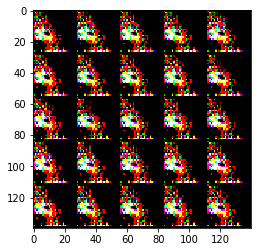

Epoch 1/1... Discriminator Loss: 0.3343... Generator Loss: 10.4704
Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 10.4800
Epoch 1/1... Discriminator Loss: 0.3293... Generator Loss: 10.6513
Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 10.7543
Epoch 1/1... Discriminator Loss: 0.3346... Generator Loss: 11.3015
Epoch 1/1... Discriminator Loss: 0.3365... Generator Loss: 10.5278
Epoch 1/1... Discriminator Loss: 0.3346... Generator Loss: 10.9982
Epoch 1/1... Discriminator Loss: 0.3284... Generator Loss: 11.1942
Epoch 1/1... Discriminator Loss: 0.3309... Generator Loss: 10.9976
Epoch 1/1... Discriminator Loss: 0.3395... Generator Loss: 10.2015


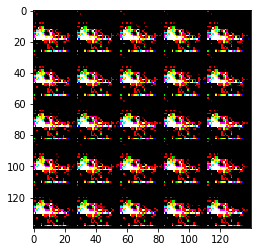

Epoch 1/1... Discriminator Loss: 0.3329... Generator Loss: 9.8420
Epoch 1/1... Discriminator Loss: 0.3473... Generator Loss: 9.2535
Epoch 1/1... Discriminator Loss: 0.3310... Generator Loss: 9.0023
Epoch 1/1... Discriminator Loss: 0.3293... Generator Loss: 9.2359
Epoch 1/1... Discriminator Loss: 0.3285... Generator Loss: 9.8032
Epoch 1/1... Discriminator Loss: 0.3302... Generator Loss: 9.6967
Epoch 1/1... Discriminator Loss: 0.3376... Generator Loss: 9.4121
Epoch 1/1... Discriminator Loss: 0.3322... Generator Loss: 10.5221
Epoch 1/1... Discriminator Loss: 0.3324... Generator Loss: 9.8317
Epoch 1/1... Discriminator Loss: 0.3343... Generator Loss: 9.5418


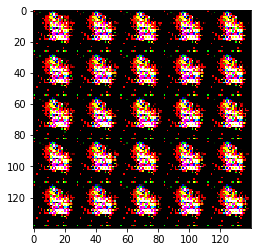

Epoch 1/1... Discriminator Loss: 0.3608... Generator Loss: 9.6797
Epoch 1/1... Discriminator Loss: 0.3342... Generator Loss: 9.9805
Epoch 1/1... Discriminator Loss: 0.3351... Generator Loss: 9.8689
Epoch 1/1... Discriminator Loss: 0.3280... Generator Loss: 9.7472
Epoch 1/1... Discriminator Loss: 0.3319... Generator Loss: 10.5977
Epoch 1/1... Discriminator Loss: 0.3284... Generator Loss: 10.1043
Epoch 1/1... Discriminator Loss: 0.3307... Generator Loss: 8.7258
Epoch 1/1... Discriminator Loss: 0.3500... Generator Loss: 8.9130
Epoch 1/1... Discriminator Loss: 0.3421... Generator Loss: 9.6474
Epoch 1/1... Discriminator Loss: 0.3287... Generator Loss: 10.0380


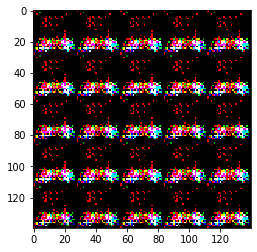

Epoch 1/1... Discriminator Loss: 0.3349... Generator Loss: 9.9288
Epoch 1/1... Discriminator Loss: 0.3313... Generator Loss: 10.2531
Epoch 1/1... Discriminator Loss: 0.3325... Generator Loss: 10.7145
Epoch 1/1... Discriminator Loss: 0.3342... Generator Loss: 10.5454
Epoch 1/1... Discriminator Loss: 0.3366... Generator Loss: 11.0465
Epoch 1/1... Discriminator Loss: 0.3280... Generator Loss: 11.3117
Epoch 1/1... Discriminator Loss: 0.3314... Generator Loss: 11.1832
Epoch 1/1... Discriminator Loss: 0.3351... Generator Loss: 11.3404
Epoch 1/1... Discriminator Loss: 0.3293... Generator Loss: 10.9053
Epoch 1/1... Discriminator Loss: 0.3312... Generator Loss: 10.7505


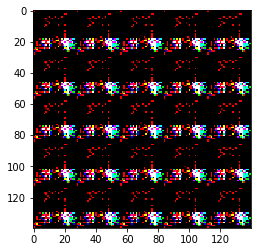

Epoch 1/1... Discriminator Loss: 0.3276... Generator Loss: 10.9450
Epoch 1/1... Discriminator Loss: 0.3336... Generator Loss: 11.0341
Epoch 1/1... Discriminator Loss: 0.3291... Generator Loss: 11.2413
Epoch 1/1... Discriminator Loss: 0.3333... Generator Loss: 10.7803
Epoch 1/1... Discriminator Loss: 0.3290... Generator Loss: 10.7928
Epoch 1/1... Discriminator Loss: 0.3305... Generator Loss: 11.4328
Epoch 1/1... Discriminator Loss: 0.3289... Generator Loss: 11.1661
Epoch 1/1... Discriminator Loss: 0.3415... Generator Loss: 10.6593
Epoch 1/1... Discriminator Loss: 0.3288... Generator Loss: 11.0185
Epoch 1/1... Discriminator Loss: 0.3357... Generator Loss: 11.3237


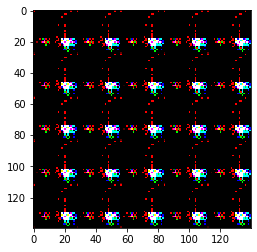

Epoch 1/1... Discriminator Loss: 0.3317... Generator Loss: 11.4408
Epoch 1/1... Discriminator Loss: 0.3357... Generator Loss: 11.1086
Epoch 1/1... Discriminator Loss: 0.3357... Generator Loss: 11.0918
Epoch 1/1... Discriminator Loss: 0.3292... Generator Loss: 11.0537
Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 10.5302
Epoch 1/1... Discriminator Loss: 0.3300... Generator Loss: 10.9571
Epoch 1/1... Discriminator Loss: 0.3307... Generator Loss: 11.3709
Epoch 1/1... Discriminator Loss: 0.4115... Generator Loss: 11.4021
Epoch 1/1... Discriminator Loss: 0.3424... Generator Loss: 11.6292
Epoch 1/1... Discriminator Loss: 0.3395... Generator Loss: 11.5296


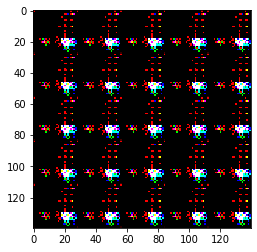

Epoch 1/1... Discriminator Loss: 0.3289... Generator Loss: 11.5067
Epoch 1/1... Discriminator Loss: 0.3302... Generator Loss: 11.7197
Epoch 1/1... Discriminator Loss: 0.3308... Generator Loss: 11.7761
Epoch 1/1... Discriminator Loss: 0.3287... Generator Loss: 11.8626
Epoch 1/1... Discriminator Loss: 0.3311... Generator Loss: 10.8061
Epoch 1/1... Discriminator Loss: 0.3311... Generator Loss: 11.0889
Epoch 1/1... Discriminator Loss: 0.3319... Generator Loss: 10.1797
Epoch 1/1... Discriminator Loss: 0.3412... Generator Loss: 8.4208
Epoch 1/1... Discriminator Loss: 0.3479... Generator Loss: 7.7379
Epoch 1/1... Discriminator Loss: 0.3272... Generator Loss: 9.4871


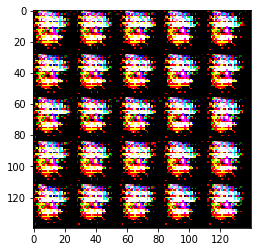

Epoch 1/1... Discriminator Loss: 0.3280... Generator Loss: 9.1606
Epoch 1/1... Discriminator Loss: 0.3305... Generator Loss: 9.7649
Epoch 1/1... Discriminator Loss: 0.3362... Generator Loss: 9.3328
Epoch 1/1... Discriminator Loss: 0.3497... Generator Loss: 9.3214
Epoch 1/1... Discriminator Loss: 0.3271... Generator Loss: 9.9618
Epoch 1/1... Discriminator Loss: 0.3285... Generator Loss: 10.2777
Epoch 1/1... Discriminator Loss: 0.3278... Generator Loss: 10.2811
Epoch 1/1... Discriminator Loss: 0.3331... Generator Loss: 10.3484
Epoch 1/1... Discriminator Loss: 0.3478... Generator Loss: 10.3462
Epoch 1/1... Discriminator Loss: 0.3317... Generator Loss: 10.2618


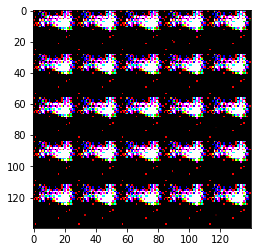

Epoch 1/1... Discriminator Loss: 0.3325... Generator Loss: 10.8660
Epoch 1/1... Discriminator Loss: 0.3284... Generator Loss: 11.0112
Epoch 1/1... Discriminator Loss: 0.3329... Generator Loss: 10.4942
Epoch 1/1... Discriminator Loss: 0.3265... Generator Loss: 10.4855
Epoch 1/1... Discriminator Loss: 0.3332... Generator Loss: 10.6113
Epoch 1/1... Discriminator Loss: 0.3350... Generator Loss: 11.1087
Epoch 1/1... Discriminator Loss: 0.3336... Generator Loss: 10.3547
Epoch 1/1... Discriminator Loss: 0.3310... Generator Loss: 10.6044
Epoch 1/1... Discriminator Loss: 0.3414... Generator Loss: 10.7857
Epoch 1/1... Discriminator Loss: 0.3263... Generator Loss: 11.1002


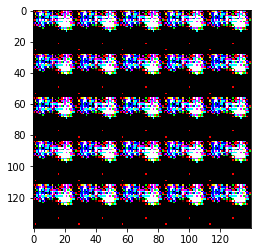

Epoch 1/1... Discriminator Loss: 0.3271... Generator Loss: 10.4311
Epoch 1/1... Discriminator Loss: 0.3287... Generator Loss: 10.1185
Epoch 1/1... Discriminator Loss: 0.3276... Generator Loss: 10.7144
Epoch 1/1... Discriminator Loss: 0.4189... Generator Loss: 9.3538
Epoch 1/1... Discriminator Loss: 0.3306... Generator Loss: 10.5331
Epoch 1/1... Discriminator Loss: 0.3284... Generator Loss: 10.1885
Epoch 1/1... Discriminator Loss: 0.3275... Generator Loss: 10.1079
Epoch 1/1... Discriminator Loss: 0.3286... Generator Loss: 10.5398
Epoch 1/1... Discriminator Loss: 0.3270... Generator Loss: 10.4530
Epoch 1/1... Discriminator Loss: 0.3492... Generator Loss: 10.3418


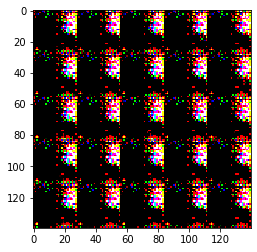

Epoch 1/1... Discriminator Loss: 0.3352... Generator Loss: 9.0484
Epoch 1/1... Discriminator Loss: 0.3282... Generator Loss: 8.8391
Epoch 1/1... Discriminator Loss: 0.3285... Generator Loss: 9.4309
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 8.2738
Epoch 1/1... Discriminator Loss: 0.3330... Generator Loss: 10.2234
Epoch 1/1... Discriminator Loss: 0.3381... Generator Loss: 9.6102
Epoch 1/1... Discriminator Loss: 0.3312... Generator Loss: 10.6090
Epoch 1/1... Discriminator Loss: 0.3293... Generator Loss: 10.2510
Epoch 1/1... Discriminator Loss: 0.3269... Generator Loss: 10.2184
Epoch 1/1... Discriminator Loss: 0.3275... Generator Loss: 10.5537


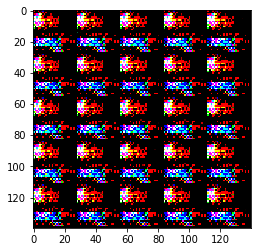

Epoch 1/1... Discriminator Loss: 0.3289... Generator Loss: 10.9718
Epoch 1/1... Discriminator Loss: 0.3338... Generator Loss: 10.1008
Epoch 1/1... Discriminator Loss: 0.3290... Generator Loss: 10.5240
Epoch 1/1... Discriminator Loss: 0.3429... Generator Loss: 10.9693
Epoch 1/1... Discriminator Loss: 0.3314... Generator Loss: 10.2892
Epoch 1/1... Discriminator Loss: 0.3297... Generator Loss: 10.5987
Epoch 1/1... Discriminator Loss: 0.3313... Generator Loss: 10.2004
Epoch 1/1... Discriminator Loss: 0.3339... Generator Loss: 9.3695
Epoch 1/1... Discriminator Loss: 0.3265... Generator Loss: 10.1130
Epoch 1/1... Discriminator Loss: 0.3275... Generator Loss: 10.5295


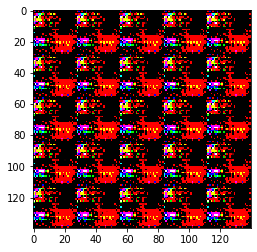

Epoch 1/1... Discriminator Loss: 0.3344... Generator Loss: 9.9104
Epoch 1/1... Discriminator Loss: 0.3284... Generator Loss: 11.0998
Epoch 1/1... Discriminator Loss: 0.3272... Generator Loss: 10.8814
Epoch 1/1... Discriminator Loss: 0.3277... Generator Loss: 11.0865
Epoch 1/1... Discriminator Loss: 0.3326... Generator Loss: 11.1140
Epoch 1/1... Discriminator Loss: 0.3451... Generator Loss: 10.6555
Epoch 1/1... Discriminator Loss: 0.3386... Generator Loss: 10.6430
Epoch 1/1... Discriminator Loss: 0.3311... Generator Loss: 10.4238
Epoch 1/1... Discriminator Loss: 0.3340... Generator Loss: 10.2672
Epoch 1/1... Discriminator Loss: 0.3269... Generator Loss: 10.8105


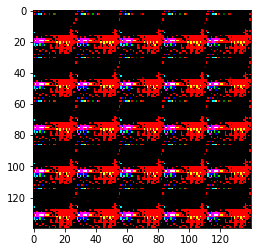

Epoch 1/1... Discriminator Loss: 0.3314... Generator Loss: 10.6348
Epoch 1/1... Discriminator Loss: 0.3276... Generator Loss: 11.2480
Epoch 1/1... Discriminator Loss: 0.3330... Generator Loss: 11.3905
Epoch 1/1... Discriminator Loss: 0.3300... Generator Loss: 11.1621
Epoch 1/1... Discriminator Loss: 0.3293... Generator Loss: 9.1607
Epoch 1/1... Discriminator Loss: 0.3281... Generator Loss: 8.9105
Epoch 1/1... Discriminator Loss: 0.3327... Generator Loss: 9.1164
Epoch 1/1... Discriminator Loss: 0.3280... Generator Loss: 9.9827
Epoch 1/1... Discriminator Loss: 0.3337... Generator Loss: 10.2500
Epoch 1/1... Discriminator Loss: 0.3283... Generator Loss: 10.0661


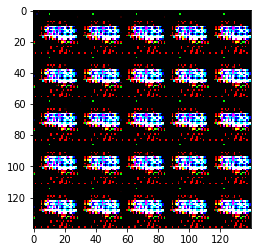

Epoch 1/1... Discriminator Loss: 0.3263... Generator Loss: 10.1893
Epoch 1/1... Discriminator Loss: 0.3415... Generator Loss: 10.5289
Epoch 1/1... Discriminator Loss: 0.3266... Generator Loss: 10.7097
Epoch 1/1... Discriminator Loss: 0.3323... Generator Loss: 11.2416
Epoch 1/1... Discriminator Loss: 0.3546... Generator Loss: 10.2840
Epoch 1/1... Discriminator Loss: 0.3266... Generator Loss: 10.8607
Epoch 1/1... Discriminator Loss: 0.3387... Generator Loss: 10.5904
Epoch 1/1... Discriminator Loss: 0.3345... Generator Loss: 10.3623
Epoch 1/1... Discriminator Loss: 0.3274... Generator Loss: 10.7849
Epoch 1/1... Discriminator Loss: 0.3266... Generator Loss: 10.6291


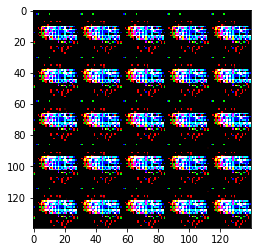

Epoch 1/1... Discriminator Loss: 0.3288... Generator Loss: 10.4910
Epoch 1/1... Discriminator Loss: 0.3282... Generator Loss: 9.5164
Epoch 1/1... Discriminator Loss: 0.3311... Generator Loss: 8.2878
Epoch 1/1... Discriminator Loss: 0.3312... Generator Loss: 9.5655
Epoch 1/1... Discriminator Loss: 0.3285... Generator Loss: 10.0533
Epoch 1/1... Discriminator Loss: 0.3539... Generator Loss: 9.7583
Epoch 1/1... Discriminator Loss: 0.3271... Generator Loss: 9.9974
Epoch 1/1... Discriminator Loss: 0.3262... Generator Loss: 9.4680
Epoch 1/1... Discriminator Loss: 0.3308... Generator Loss: 10.2526
Epoch 1/1... Discriminator Loss: 0.3342... Generator Loss: 9.6812


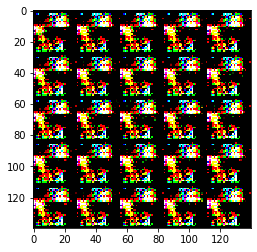

Epoch 1/1... Discriminator Loss: 0.3274... Generator Loss: 9.2256
Epoch 1/1... Discriminator Loss: 0.3314... Generator Loss: 9.7558
Epoch 1/1... Discriminator Loss: 0.3289... Generator Loss: 10.0246
Epoch 1/1... Discriminator Loss: 0.3306... Generator Loss: 10.4416
Epoch 1/1... Discriminator Loss: 0.3297... Generator Loss: 10.1428
Epoch 1/1... Discriminator Loss: 0.3260... Generator Loss: 10.0492
Epoch 1/1... Discriminator Loss: 0.3292... Generator Loss: 10.9130
Epoch 1/1... Discriminator Loss: 0.3282... Generator Loss: 10.8336
Epoch 1/1... Discriminator Loss: 0.3286... Generator Loss: 10.0427
Epoch 1/1... Discriminator Loss: 0.3300... Generator Loss: 10.3799


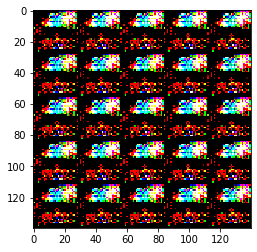

Epoch 1/1... Discriminator Loss: 0.3315... Generator Loss: 10.4794
Epoch 1/1... Discriminator Loss: 0.3280... Generator Loss: 10.0641
Epoch 1/1... Discriminator Loss: 0.3366... Generator Loss: 11.1546
Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 9.8932
Epoch 1/1... Discriminator Loss: 0.3383... Generator Loss: 10.2510
Epoch 1/1... Discriminator Loss: 0.3274... Generator Loss: 11.1222
Epoch 1/1... Discriminator Loss: 0.3347... Generator Loss: 10.2045
Epoch 1/1... Discriminator Loss: 0.3285... Generator Loss: 10.7225
Epoch 1/1... Discriminator Loss: 0.3347... Generator Loss: 10.8158
Epoch 1/1... Discriminator Loss: 0.3294... Generator Loss: 10.9333


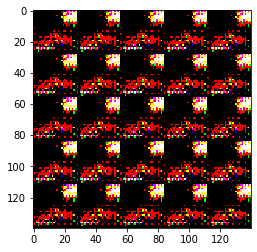

Epoch 1/1... Discriminator Loss: 0.3295... Generator Loss: 10.4058
Epoch 1/1... Discriminator Loss: 0.3419... Generator Loss: 9.7168
Epoch 1/1... Discriminator Loss: 0.3266... Generator Loss: 10.1407
Epoch 1/1... Discriminator Loss: 0.3265... Generator Loss: 10.3116
Epoch 1/1... Discriminator Loss: 0.3309... Generator Loss: 10.9286
Epoch 1/1... Discriminator Loss: 0.3378... Generator Loss: 10.9097
Epoch 1/1... Discriminator Loss: 0.3304... Generator Loss: 10.9000
Epoch 1/1... Discriminator Loss: 0.3360... Generator Loss: 10.8477
Epoch 1/1... Discriminator Loss: 0.3279... Generator Loss: 10.7184
Epoch 1/1... Discriminator Loss: 0.3271... Generator Loss: 9.3486


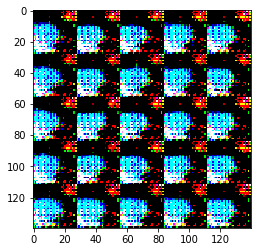

KeyboardInterrupt: 

In [122]:
batch_size = 32
z_dim = 100
learning_rate = 0.0006
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.